## Optimal Hub determination

## Short Case description

In the underlying case, I aim to introduce a hub at an optimal location based on historical truck delivery routes data. 
For this case, I will only use the destination coordinates of the routes and assume the starting positions of the trucks to be unknown, as the goal of this project is to find a location that is optimal for all destinations. The reason behind that is that Hubs can be used as depots, increase efficiency in transportation through bundling, etc.. In this case, I simply want to assume a central starting point for all outgoing deliveries to the different destinations and try to find the optimal depot location accordingly.

For simplicity, I will work with haversine distances between the different coordinates.

I will first performe clustering on the different nodes in the distribution network and try to identify potential hub locations. 

Based on these potential locations, I will run a Gurobi optimization model that chooses the hub location, which minimizes the sum of all distances travelled for all deliveries in the dataset.

In [51]:
# load packages
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import pgeocode as pg
import folium
import geopandas as gpd
from folium import plugins
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import gurobipy as gp
from gurobipy import Model, GRB

In [3]:
# import dataset

df = pd.read_excel(r"C:\Users\felix\OneDrive\Dokumente\Python Projects\Optimization Model Gurobi\Delivery truck trip data.xlsx")

df

,GpsProvider,BookingID,Market/Regular,BookingID_Date,vehicle_no,Origin_Location,Destination_Location,Org_lat_lon,Des_lat_lon,Data_Ping_time,...,TRANSPORTATION_DISTANCE_IN_KM,vehicleType,Minimum_kms_to_be_covered_in_a_day,Driver_Name,Driver_MobileNo,customerID,customerNameCode,supplierID,supplierNameCode,Material Shipped
0,CONSENT TRACK,MVCV0000927/082021,Market,2020-08-17 14:59:01.000,KA590408,"TVSLSL-PUZHAL-HUB,CHENNAI,TAMIL NADU","ASHOK LEYLAND PLANT 1- HOSUR,HOSUR,KARNATAKA","13.1550,80.1960","12.7400,77.8200",2020-08-24 00:05:09,...,320.0,NaN,NaN,NaN,NaN,ALLEXCHE45,Ashok leyland limited,VIJEXHOSR7,VIJAY TRANSPORT,BRACKET / GRAB HANDLE
1,VAMOSYS,VCV00014271/082021,Regular,2020-08-27 16:22:22.827,TN30BC5917,"DAIMLER INDIA COMMERCIAL VEHICLES,KANCHIPURAM,...","DAIMLER INDIA COMMERCIAL VEHICLES,KANCHIPURAM,...","12.8390,79.9540","12.8390,79.9540",2020-08-28 12:40:28,...,103.0,NaN,NaN,RAMESH,NaN,DMREXCHEUX,Daimler india commercial vehicles pvt lt,VJLEXSHE09,VJ LOGISTICS,ZB MODEL PLATE / 3143
2,CONSENT TRACK,VCV00014382/082021,Regular,2020-08-27 17:59:24.987,TN22AR2748,"LUCAS TVS LTD-PONDY,PONDY,PONDICHERRY","LUCAS TVS LTD-PONDY,PONDY,PONDICHERRY","11.8710,79.7390","11.8710,79.7390",2020-08-28 09:05:09,...,300.0,NaN,NaN,GIRI,NaN,LUTGCCHE06,Lucas tvs ltd,GSTEXLAK1Q,G.S. TRANSPORT,LETTERING / FUSO
3,VAMOSYS,VCV00014743/082021,Regular,2020-08-28 00:48:24.503,TN28AQ0781,"DAIMLER INDIA COMMERCIAL VEHICLES,KANCHIPURAM,...","DAIMLER INDIA COMMERCIAL VEHICLES,KANCHIPURAM,...","12.8390,79.9540","12.8390,79.9540",2020-08-28 12:40:31,...,61.0,NaN,NaN,RAVI,NaN,DMREXCHEUX,Daimler india commercial vehicles pvt lt,ARVEXNAM09,ARVINTH TRANSPORT,LU STRUT RA / RADIUS ROD
4,VAMOSYS,VCV00014744/082021,Regular,2020-08-28 01:23:19.243,TN68F1722,"LUCAS TVS LTD-PONDY,PONDY,PONDICHERRY","LUCAS TVS LTD-PONDY,PONDY,PONDICHERRY","11.8720,79.6320","11.8720,79.6320",2020-08-28 12:40:29,...,240.0,NaN,NaN,TAMIL,NaN,LUTGCCHE06,Lucas tvs ltd,SRTEXKOR96,SR TRANSPORTS,WISHBONE / V ROD/HDT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6875,JTECH,WDSBKTP42751,Regular,2019-03-27 17:25:33.000,KA219502,"Ramamurthy Nagar, Bangalore, Karnataka","Sahakaranagar P.O, Bangalore, Karnataka","13.007503209603689,77.665098855934886","13.068901840235711,77.590655738806618",2019-06-14 15:20:12,...,12.0,25 FT Open Body 21MT,NaN,NaN,NaN,LTLEXMUM40,Larsen & toubro limited,55556,A S TRANSPORTS,TOOL KIT SET
6876,JTECH,WDSBKTP43203,Regular,2019-03-31 15:02:34.000,KA01AE9163,"Ramamurthy Nagar, Bangalore, Karnataka","Bangalore International Airport, Bangalore, Ka...","13.007503209603689,77.665098855934886","13.196312912801169,77.708156925688726",2019-06-14 15:20:12,...,31.0,40 FT 3XL Trailer 35MT,NaN,NaN,NaN,LTLEXMUM40,Larsen & toubro limited,55556,A S TRANSPORTS,CONTROL LEVER ASSY
6877,JTECH,WDSBKTP43021,Regular,2019-03-29 18:56:26.000,KA01AE9163,"Mugabala, Bangalore Rural, Karnataka","Anekal, Bangalore, Karnataka","16.560192249175344,80.792293091599547","12.722686,77.676518",2019-06-14 15:20:12,...,49.0,40 FT 3XL Trailer 35MT,NaN,NaN,NaN,LTLEXMUM40,Larsen & toubro limited,55556,A S TRANSPORTS,SPARE PARTS AUTOMOBILE
6878,JTECH,WDSBKTP42685,Regular,2019-03-27 08:29:45.000,KA21A3643,"Mugabala, Bangalore Rural, Karnataka","Anekal, Bangalore, Karnataka","16.560192249175344,80.792293091599547","12.896896847817695,77.712223056874862",2019-06-14 15:20:12,...,49.0,40 FT 3XL Trailer 35MT,NaN,NaN,NaN,LTLEXMUM40,Larsen & toubro limited,55556,A S TRANSPORTS,SPARE PARTS AUTOMOBILE


In [4]:
df.columns

Index(['GpsProvider', 'BookingID', 'Market/Regular ', 'BookingID_Date',
       'vehicle_no', 'Origin_Location', 'Destination_Location', 'Org_lat_lon',
       'Des_lat_lon', 'Data_Ping_time', 'Planned_ETA', 'Current_Location',
       'DestinationLocation', 'actual_eta', 'Curr_lat', 'Curr_lon', 'ontime',
       'delay', 'OriginLocation_Code', 'DestinationLocation_Code',
       'trip_start_date', 'trip_end_date', 'TRANSPORTATION_DISTANCE_IN_KM',
       'vehicleType', 'Minimum_kms_to_be_covered_in_a_day', 'Driver_Name',
       'Driver_MobileNo', 'customerID', 'customerNameCode', 'supplierID',
       'supplierNameCode', 'Material Shipped'],
      dtype='object')

In [5]:
df.dtypes

GpsProvider                                   object
BookingID                                     object
Market/Regular                                object
BookingID_Date                        datetime64[ns]
vehicle_no                                    object
Origin_Location                               object
Destination_Location                          object
Org_lat_lon                                   object
Des_lat_lon                                   object
Data_Ping_time                        datetime64[ns]
Planned_ETA                                   object
Current_Location                              object
DestinationLocation                           object
actual_eta                                    object
Curr_lat                                     float64
Curr_lon                                     float64
ontime                                        object
delay                                         object
OriginLocation_Code                           

In [6]:
df[['destination_lat', 'destination_lon']] = df['Des_lat_lon'].str.split(',', n=1, expand=True)


In [7]:
df[['origin_lat', 'origin_lon']] = df['Org_lat_lon'].str.split(',', n=1, expand=True)


In [8]:
df['Org_lat_lon'].nunique()

173

In [9]:
df['Des_lat_lon'].nunique()

522

In [10]:
len(df)

6880

We see that there are only 173 unique origins and 6880 unique destinations of truck routes. This further suggests that there are recurring routes and for simplicity, this could suggest that the carrier may benefit from bundling freights together into one truck in the future. For that, relaxing the time dimension, it could be useful to introduce a hub somewhere in India. This hub could serve as an optional store place that allows to assemble muliple deliveries together and deliver it at ones on a specific route


For this purpose, our goal of this project will be to determine an optimal hub location, that we base on the following assumptions:

- We consider Haversine distances between locations, i.e. do not consider real routes that trucks would take

- We assume that all these deliveries are from one company, that delivers freights from their 173 manufacturers to the customers. In the future, they may make use of the new Hub to facilitate operations and increase efficiency.


In [11]:
df.head()

,GpsProvider,BookingID,Market/Regular,BookingID_Date,vehicle_no,Origin_Location,Destination_Location,Org_lat_lon,Des_lat_lon,Data_Ping_time,...,Driver_MobileNo,customerID,customerNameCode,supplierID,supplierNameCode,Material Shipped,destination_lat,destination_lon,origin_lat,origin_lon
0,CONSENT TRACK,MVCV0000927/082021,Market,2020-08-17 14:59:01.000,KA590408,"TVSLSL-PUZHAL-HUB,CHENNAI,TAMIL NADU","ASHOK LEYLAND PLANT 1- HOSUR,HOSUR,KARNATAKA","13.1550,80.1960","12.7400,77.8200",2020-08-24 00:05:09,...,NaN,ALLEXCHE45,Ashok leyland limited,VIJEXHOSR7,VIJAY TRANSPORT,BRACKET / GRAB HANDLE,12.7400,77.8200,13.1550,80.1960
1,VAMOSYS,VCV00014271/082021,Regular,2020-08-27 16:22:22.827,TN30BC5917,"DAIMLER INDIA COMMERCIAL VEHICLES,KANCHIPURAM,...","DAIMLER INDIA COMMERCIAL VEHICLES,KANCHIPURAM,...","12.8390,79.9540","12.8390,79.9540",2020-08-28 12:40:28,...,NaN,DMREXCHEUX,Daimler india commercial vehicles pvt lt,VJLEXSHE09,VJ LOGISTICS,ZB MODEL PLATE / 3143,12.8390,79.9540,12.8390,79.9540
2,CONSENT TRACK,VCV00014382/082021,Regular,2020-08-27 17:59:24.987,TN22AR2748,"LUCAS TVS LTD-PONDY,PONDY,PONDICHERRY","LUCAS TVS LTD-PONDY,PONDY,PONDICHERRY","11.8710,79.7390","11.8710,79.7390",2020-08-28 09:05:09,...,NaN,LUTGCCHE06,Lucas tvs ltd,GSTEXLAK1Q,G.S. TRANSPORT,LETTERING / FUSO,11.8710,79.7390,11.8710,79.7390
3,VAMOSYS,VCV00014743/082021,Regular,2020-08-28 00:48:24.503,TN28AQ0781,"DAIMLER INDIA COMMERCIAL VEHICLES,KANCHIPURAM,...","DAIMLER INDIA COMMERCIAL VEHICLES,KANCHIPURAM,...","12.8390,79.9540","12.8390,79.9540",2020-08-28 12:40:31,...,NaN,DMREXCHEUX,Daimler india commercial vehicles pvt lt,ARVEXNAM09,ARVINTH TRANSPORT,LU STRUT RA / RADIUS ROD,12.8390,79.9540,12.8390,79.9540
4,VAMOSYS,VCV00014744/082021,Regular,2020-08-28 01:23:19.243,TN68F1722,"LUCAS TVS LTD-PONDY,PONDY,PONDICHERRY","LUCAS TVS LTD-PONDY,PONDY,PONDICHERRY","11.8720,79.6320","11.8720,79.6320",2020-08-28 12:40:29,...,NaN,LUTGCCHE06,Lucas tvs ltd,SRTEXKOR96,SR TRANSPORTS,WISHBONE / V ROD/HDT,11.8720,79.6320,11.8720,79.6320


In [12]:
# Choose relevant columns for modeling

data = df[['BookingID', 'origin_lat', 'origin_lon', 'destination_lat', 'destination_lon']]

In [13]:
data[['origin_lat', 'origin_lon', 'destination_lat', 'destination_lon']] = round(data[['origin_lat', 'origin_lon', 'destination_lat', 'destination_lon']], 4).astype('float64')

C:\Users\felix\AppData\Local\Temp\ipykernel_20660\3020225103.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[['origin_lat', 'origin_lon', 'destination_lat', 'destination_lon']] = round(data[['origin_lat', 'origin_lon', 'destination_lat', 'destination_lon']], 4).astype('float64')


In [14]:
data

,BookingID,origin_lat,origin_lon,destination_lat,destination_lon
0,MVCV0000927/082021,13.155000,80.196000,12.740000,77.820000
1,VCV00014271/082021,12.839000,79.954000,12.839000,79.954000
2,VCV00014382/082021,11.871000,79.739000,11.871000,79.739000
3,VCV00014743/082021,12.839000,79.954000,12.839000,79.954000
4,VCV00014744/082021,11.872000,79.632000,11.872000,79.632000
...,...,...,...,...,...
6875,WDSBKTP42751,13.007503,77.665099,13.068902,77.590656
6876,WDSBKTP43203,13.007503,77.665099,13.196313,77.708157
6877,WDSBKTP43021,16.560192,80.792293,12.722686,77.676518
6878,WDSBKTP42685,16.560192,80.792293,12.896897,77.712223


In [15]:
data['BookingID'].nunique()

6875

In [16]:
# delete duplicates based on bookingID

data = data.drop_duplicates(subset='BookingID', keep=False)

data

,BookingID,origin_lat,origin_lon,destination_lat,destination_lon
0,MVCV0000927/082021,13.155000,80.196000,12.740000,77.820000
1,VCV00014271/082021,12.839000,79.954000,12.839000,79.954000
2,VCV00014382/082021,11.871000,79.739000,11.871000,79.739000
3,VCV00014743/082021,12.839000,79.954000,12.839000,79.954000
4,VCV00014744/082021,11.872000,79.632000,11.872000,79.632000
...,...,...,...,...,...
6875,WDSBKTP42751,13.007503,77.665099,13.068902,77.590656
6876,WDSBKTP43203,13.007503,77.665099,13.196313,77.708157
6877,WDSBKTP43021,16.560192,80.792293,12.722686,77.676518
6878,WDSBKTP42685,16.560192,80.792293,12.896897,77.712223


In [17]:
# Calculate Distances between origin and destination for each Booking_ID

import math
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 
    return c * r

data['Dist_Origin_Dest'] = data.apply(lambda row: haversine(row['origin_lon'], row['origin_lat'], row['destination_lon'], row['destination_lat']), axis=1)

data.head()


C:\Users\felix\AppData\Local\Temp\ipykernel_20660\2027153707.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Dist_Origin_Dest'] = data.apply(lambda row: haversine(row['origin_lon'], row['origin_lat'], row['destination_lon'], row['destination_lat']), axis=1)


,BookingID,origin_lat,origin_lon,destination_lat,destination_lon,Dist_Origin_Dest
0,MVCV0000927/082021,13.155,80.196,12.740,77.820,261.582982
1,VCV00014271/082021,12.839,79.954,12.839,79.954,0.000000
2,VCV00014382/082021,11.871,79.739,11.871,79.739,0.000000
3,VCV00014743/082021,12.839,79.954,12.839,79.954,0.000000
4,VCV00014744/082021,11.872,79.632,11.872,79.632,0.000000


c:\Users\felix\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Dist_Origin_Dest', ylabel='Count'>

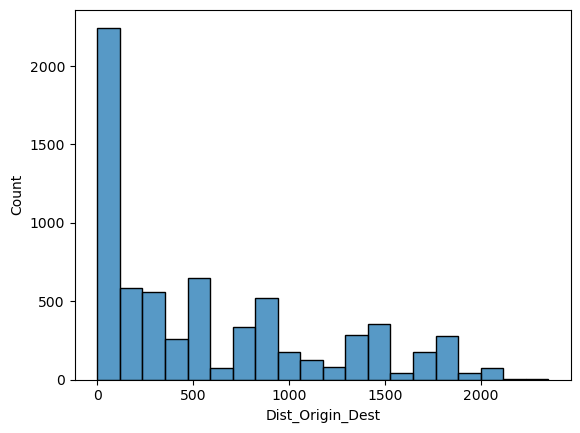

In [18]:
sns.histplot(data=data['Dist_Origin_Dest'], bins= 20)

In [19]:
data['Dist_Origin_Dest'].describe(percentiles=[.25,.50,.75])

count    6871.000000
mean      579.474152
std       591.310737
min         0.000000
25%        35.881408
50%       383.654437
75%       922.473022
max      2349.085481
Name: Dist_Origin_Dest, dtype: float64

This distribution of direct distances suggests that many of the routes would probably not need a hub in between, assuming that a truck can easily drive 500-800 km in one day.

Let's now check how the dots are distributed on the map.

In [21]:
from folium.plugins import HeatMap

manufacturers = data[['origin_lat', 'origin_lon']].drop_duplicates()
customers = data[['destination_lat', 'destination_lon']].drop_duplicates()

mymap = folium.Map(location=[20.5937, 78.9629], zoom_start=5)

manufacturers_list = manufacturers[['origin_lat', 'origin_lon']].values.tolist()
customers_list = customers[['destination_lat', 'destination_lon']].values.tolist()

heat_map_manufacturers = HeatMap(manufacturers_list, radius=15, blur=20, max_zoom=13, gradient={0.4: 'blue', 0.6: 'cyan', 1: 'lime'})
heat_map_customers = HeatMap(customers_list, radius=15, blur=20, max_zoom=13, gradient={0.4: 'red', 0.6: 'orange', 1: 'yellow'})

mymap.add_child(heat_map_manufacturers)
mymap.add_child(heat_map_customers)

mymap

### Clustering: Find potential hubs

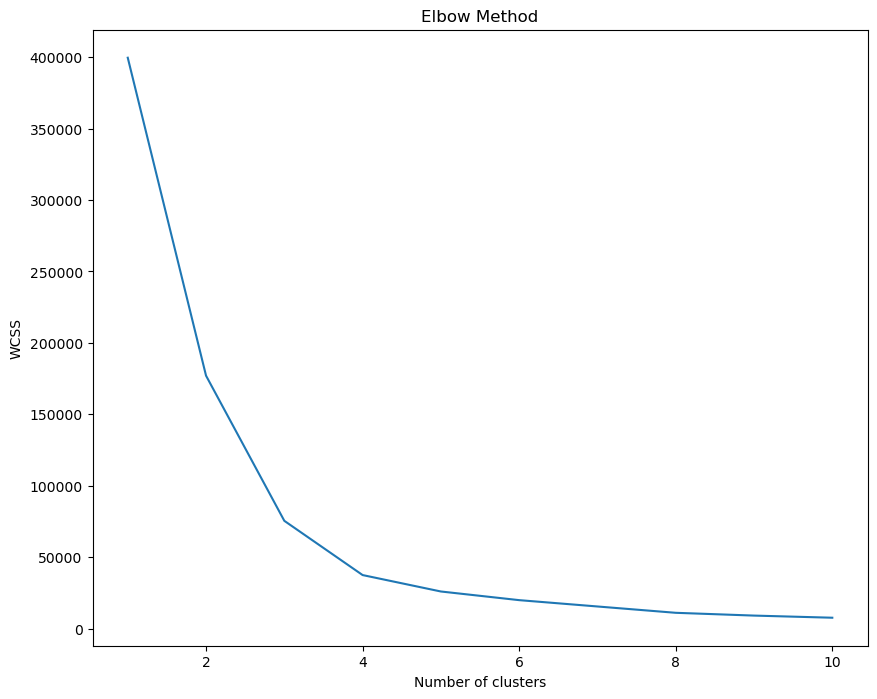

In [22]:
# Feature selection
X = data[['destination_lon', 'destination_lat']]

# Calculate WCSS (Within-Cluster-Sum-of-Squares)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 8))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  
plt.show()


In [23]:
# KMeans with 4 clusters
kmeans = KMeans(n_clusters=4) 

kmeans.fit(X)

data['cluster_label_k4'] = kmeans.predict(X)

# Finding the centroid or mean location for each cluster, which can be considered as a potential location for a new hub.
centroid_locations_K_4 = data.groupby('cluster_label_k4')[['destination_lat', 'destination_lon']].mean().reset_index()

print(centroid_locations_K_4)

c:\Users\felix\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


   cluster_label_k4  destination_lat  destination_lon
0                 0        13.394364        78.760264
1                 1        28.592571        77.025476
2                 2        23.599392        87.313476
3                 3        21.120285        73.020508


C:\Users\felix\AppData\Local\Temp\ipykernel_20660\3572087782.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cluster_label_k4'] = kmeans.predict(X)


In [24]:
centroid_locations_K_4 = centroid_locations_K_4.rename(columns={'cluster_label_k4':'cluster_label', 'destination_lat': 'hub_lat', 'destination_lon': 'hub_lon'})

centroid_locations_K_4

,cluster_label,hub_lat,hub_lon
0,0,13.394364,78.760264
1,1,28.592571,77.025476
2,2,23.599392,87.313476
3,3,21.120285,73.020508


In [25]:
# Counting the number of customers in each cluster
cluster_counts_4 = data.groupby('cluster_label_k4').size()

print(cluster_counts_4)
print(cluster_counts_4.sum())
len(data)

cluster_label_k4
0    3608
1    1098
2    1135
3    1030
dtype: int64
6871


6871

In [26]:
# Initializing KMeans with 3 clusters
kmeans = KMeans(n_clusters=3) 

kmeans.fit(X)

data['cluster_label_k3'] = kmeans.predict(X)

# Finding the centroid or mean location for each cluster, which can be considered as a potential location for a new hub.
centroid_locations_K_3 = data.groupby('cluster_label_k3')[['destination_lat', 'destination_lon']].mean().reset_index()

print(centroid_locations_K_3)

c:\Users\felix\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


   cluster_label_k3  destination_lat  destination_lon
0                 0        25.031242        75.075131
1                 1        13.417689        78.741441
2                 2        23.610512        87.294323


C:\Users\felix\AppData\Local\Temp\ipykernel_20660\650691734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cluster_label_k3'] = kmeans.predict(X)


In [27]:
centroid_locations_K_3 = centroid_locations_K_3.rename(columns={'cluster_label_k3':'cluster_label', 'destination_lat': 'hub_lat', 'destination_lon': 'hub_lon'})

centroid_locations_K_3

,cluster_label,hub_lat,hub_lon
0,0,25.031242,75.075131
1,1,13.417689,78.741441
2,2,23.610512,87.294323


In [28]:
potential_hubs_k4 = centroid_locations_K_4[['hub_lat', 'hub_lon']]
potential_hubs_k3 = centroid_locations_K_3[['hub_lat', 'hub_lon']]


hub_map = folium.Map(location=[20.5937, 78.9629], zoom_start=5)

for index, row in potential_hubs_k4.iterrows():
    folium.Marker(location=[row['hub_lat'], row['hub_lon']], icon=folium.Icon(color='red')).add_to(hub_map)

for index, row in potential_hubs_k3.iterrows():
    folium.Marker(location=[row['hub_lat'], row['hub_lon']], icon=folium.Icon(color='blue')).add_to(hub_map) 

hub_map

In [29]:
potential_hubs = pd.concat([centroid_locations_K_3,centroid_locations_K_4], 
                   ignore_index=True)

potential_hubs["cluster_label"] = potential_hubs.index

potential_hubs

,cluster_label,hub_lat,hub_lon
0,0,25.031242,75.075131
1,1,13.417689,78.741441
2,2,23.610512,87.294323
3,3,13.394364,78.760264
4,4,28.592571,77.025476
5,5,23.599392,87.313476
6,6,21.120285,73.020508


Due to high geographical overlap of cluster centroid pairs 1,3 and 2,4, I will drop cluster centroids 3 and 4 from the list of potential hubs

In [30]:
potential_hubs = potential_hubs.drop([3,4])

potential_hubs = potential_hubs.reset_index()

potential_hubs

,index,cluster_label,hub_lat,hub_lon
0,0,0,25.031242,75.075131
1,1,1,13.417689,78.741441
2,2,2,23.610512,87.294323
3,5,5,23.599392,87.313476
4,6,6,21.120285,73.020508


In [31]:
final_hub_map = folium.Map(location=[20.5937, 78.9629], zoom_start=5)

for index, row in potential_hubs.iterrows():
    folium.Marker(location=[row['hub_lat'], row['hub_lon']], icon=folium.Icon(color='red')).add_to(final_hub_map)

final_hub_map

Now, create dictionaries to calculate partial routes from origin to hub and hub to destination (for each hub)

In [32]:
dist_man_hub_with_booking_id = {}
dist_hub_dest_with_booking_id = {}

# Iterate over each new potential hub
for _, hub_row in potential_hubs.iterrows():
    cluster_label = hub_row['cluster_label']
    hub_lat = hub_row['hub_lat']
    hub_lon = hub_row['hub_lon']

    for index, row in data.iterrows():
        origin_lon = row['origin_lon']
        origin_lat = row['origin_lat']
        dest_lon = row['destination_lon']
        dest_lat = row['destination_lat']

        dist_man_hub_with_booking_id[(row['BookingID'], cluster_label, origin_lon, origin_lat)] = haversine(origin_lon, origin_lat, hub_lon, hub_lat)
        dist_hub_dest_with_booking_id[(row['BookingID'], cluster_label, dest_lon, dest_lat)] = haversine(hub_lon, hub_lat, dest_lon, dest_lat)


In [33]:
# check dictionaries
dist_man_hub_with_booking_id

{('MVCV0000927/082021', 0.0, 80.196, 13.155): 1425.494539032078,
 ('VCV00014271/082021', 0.0, 79.954, 12.839): 1449.1109477818616,
 ('VCV00014382/082021', 0.0, 79.739, 11.871): 1543.3627848863885,
 ('VCV00014743/082021', 0.0, 79.954, 12.839): 1449.1109477818616,
 ('VCV00014744/082021', 0.0, 79.632, 11.872): 1539.7177978165691,
 ('VCV00014749/082021', 0.0, 79.954, 12.839): 1449.1109477818616,
 ('VCV00014750/082021', 0.0, 79.954, 12.839): 1449.1109477818616,
 ('VCV00014812/082021', 0.0, 79.954, 12.839): 1449.1109477818616,
 ('MVCV0001769/082021', 0.0, 80.32, 13.215): 1424.2481839020945,
 ('VCV00014665/082021', 0.0, 79.954, 12.839): 1449.1109477818616,
 ('VCV00014745/082021', 0.0, 79.954, 12.839): 1449.1109477818616,
 ('VCV00014866/082021', 0.0, 77.804, 12.751): 1395.2007430078438,
 ('VCV00014879/082021', 0.0, 79.954, 12.839): 1449.1109477818616,
 ('VCV00014872/082021', 0.0, 79.954, 12.839): 1449.1109477818616,
 ('VCV00014554/082021', 0.0, 79.954, 12.839): 1449.1109477818616,
 ('VCV000145

In [34]:
len(dist_man_hub_with_booking_id)

34355

In [35]:
len(dist_hub_dest_with_booking_id)

34355

# Gurobi Model: one hub

In [36]:
hubs = [0.0, 1.0, 2.0, 5.0, 6.0]

model = Model('LogisticsOptimization')

# Decision Variables
X_ih = model.addVars(dist_man_hub_with_booking_id.keys(), vtype=GRB.BINARY, name="X_ih")
X_hk = model.addVars(dist_hub_dest_with_booking_id.keys(), vtype=GRB.BINARY, name="X_hk")
Y_h = model.addVars(hubs, vtype=GRB.BINARY, name="Y_h")

# Objective Function
model.setObjective(
    sum(dist_man_hub_with_booking_id[i] * X_ih[i] for i in dist_man_hub_with_booking_id.keys()) +
    sum(dist_hub_dest_with_booking_id[k] * X_hk[k] for k in dist_hub_dest_with_booking_id.keys()),
    GRB.MINIMIZE
)

# Constraints
# Ensure each manufacturer is connected to the hub
for i, h, k, j in dist_man_hub_with_booking_id.keys():
    model.addConstr(sum(X_ih[i, h, k, j] for h in hubs) == 1)

# Ensure each customer region is connected to exactly one hub
for i, h, k, j in dist_hub_dest_with_booking_id.keys():
    model.addConstr(sum(X_hk[i, h, k, j] for h in hubs) == 1)


# make sure that hub allocation only considers the one hub that the model chooses
# Manufacturer-Hub
for i, h, k, j in dist_man_hub_with_booking_id.keys():
    model.addConstr(X_ih[i, h, k, j] <= Y_h[h], f"ManHubActive_{i}_{h}_{k}_{j}")

# Hub-Destination
for i, h, k, j in dist_hub_dest_with_booking_id.keys():
    model.addConstr(X_hk[i, h, k, j] <= Y_h[h], f"ManHubActive_{i}_{h}_{k}_{j}")


# We allow for p hubs to be open
p = 1
model.addConstr(sum(Y_h[h] for h in hubs) == p)


# Optimize the model
model.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-31
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 PRO 5850U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 137421 rows, 68715 columns and 480975 nonzeros
Model fingerprint: 0x29c1d203
Variable types: 0 continuous, 68715 integer (68715 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e+00, 2e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 137421 rows and 68715 columns
Presolve time: 1.53s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 1.63 seconds (1.08 work units)
Thread count was 1 (of 16 available processors)

Solution count 1: 1.00556e+07 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.005558210640e+07, best bound 1.005558210640

Please note that additional constraints would be necessary to enforce a model with more than one Hub. Additionally to the model with one hub, we would need to ensure that for each bookingID, both parts of the route are connected through the same hub.

In [40]:
active_hubs = []
for h in hubs:
    if Y_h[h].x == 1:  
        active_hubs.append(h)

print("Active Hubs:", active_hubs)


Active Hubs: [1.0]


In [44]:
if model.status == GRB.OPTIMAL:
    solution_X_ih = model.getAttr('X', X_ih)
    solution_X_hk = model.getAttr('X', X_hk)
    solution_Y_h = model.getAttr('X', Y_h)

    active_hubs_ih = {key: value for key, value in solution_X_ih.items() if key[1] == 1.0 and value == 1}
    active_hubs_hk = {key: value for key, value in solution_X_hk.items() if key[1] == 1.0 and value == 1}
    active_hubs = {key: value for key, value in solution_Y_h.items() if value == 1}

    print(f"Count of cases where '1' is active in X_ih: {len(active_hubs_ih)}")
    print(f"Count of cases where '1' is active in X_hk: {len(active_hubs_hk)}")
    print(f"Count of active hubs: {len(active_hubs)}")

Count of cases where '1' is active in X_ih: 6871
Count of cases where '1' is active in X_hk: 6871
Count of active hubs: 1


In [49]:
# define chosen hub from potential hub df
chosen_hub = potential_hubs.loc[1]

chosen_hub_map = folium.Map(location=[20.5937, 78.9629], zoom_start=5)

folium.Marker(location=[chosen_hub['hub_lat'], chosen_hub['hub_lon']], icon=folium.Icon(color='red')).add_to(chosen_hub_map)

# Display the map
chosen_hub_map

In [47]:
chosen_hub

index             1.000000
cluster_label     1.000000
hub_lat          13.417689
hub_lon          78.741441
Name: 1, dtype: float64

The optimal hub is located far in the south of India. While this could be explained by the high concentration of deliveries in that region, we could also think intuitively that an optimal hub should rather be placed in the center of the country, at least if deliveries also occur accross the country for many kilometers. If the distances remain rather low (e.g. <500km), it would indeed make more sense to place a hub in one of the most dense delivery areas.


Let's further explore the data to validate this reasoning.

<Axes: xlabel='Dist_Origin_Dest', ylabel='Count'>

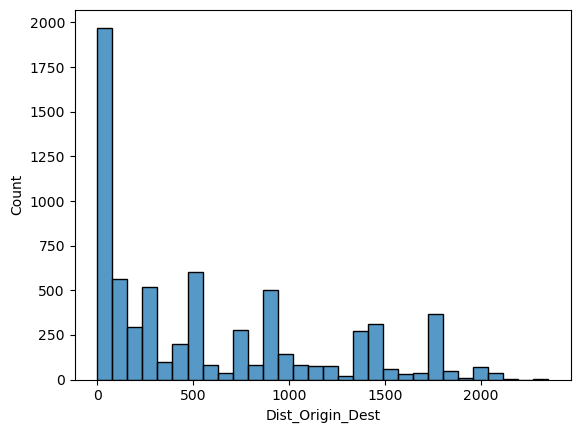

In [52]:
sns.histplot(data=data['Dist_Origin_Dest'], bins=30)

In [53]:
data['Dist_Origin_Dest'].describe(percentiles=[.25,.50,.75])

count    6871.000000
mean      579.474152
std       591.310737
min         0.000000
25%        35.881408
50%       383.654437
75%       922.473022
max      2349.085481
Name: Dist_Origin_Dest, dtype: float64

As we can see from the distribution of distances in the dataset, we have predominantly smaller distances. In fact, 50% of the distances stay below 400km, while 75% of the deliveries stay under a distance of 923km.

This gives support to our reasoning. Let's now confirm this by illustrating a distance of xxx km on the map of India.

In [57]:
dist_vis = data.loc[(data['Dist_Origin_Dest'] > 900) & (data['Dist_Origin_Dest'] < 1000)].reset_index()

dist_vis

,index,BookingID,origin_lat,origin_lon,destination_lat,destination_lon,Dist_Origin_Dest,cluster_label_k4,cluster_label_k3
0,70,AEIBK2026922,18.750621,73.877190,13.087428,80.184717,922.473022,0,1
1,84,AEIBK2027485,18.750621,73.877190,13.202214,80.131693,909.504643,0,1
2,90,AEIBK2027303,18.750621,73.877190,13.202214,80.131693,909.504643,0,1
3,95,AEIBK2027255,18.750621,73.877190,12.930429,79.931163,915.289555,0,1
4,97,AEIBK2027295,12.930429,79.931163,18.750621,73.877190,915.289555,3,0
...,...,...,...,...,...,...,...,...,...
480,6411,WDSBKTP49217,16.560192,80.792293,23.514863,85.289383,904.618717,2,2
481,6745,WDSBKTP43175,12.834174,79.703640,21.278657,81.866144,966.650586,2,2
482,6808,WDSBKTP46742,12.837284,79.704174,21.278657,81.866144,966.300731,2,2
483,6809,WDSBKTP46743,12.837284,79.704174,21.278657,81.866144,966.300731,2,2


In [59]:
# Identified index 0 being the median distance -> illustrate this observation

example_dist = dist_vis.loc[0]

example_dist

index                         70
BookingID           AEIBK2026922
origin_lat             18.750621
origin_lon              73.87719
destination_lat        13.087428
destination_lon        80.184717
Dist_Origin_Dest      922.473022
cluster_label_k4               0
cluster_label_k3               1
Name: 0, dtype: object

In [61]:
example_dist_map = folium.Map(location=[20.5937, 78.9629], zoom_start=5)

folium.Marker(location=[example_dist['origin_lat'], example_dist['origin_lon']], icon=folium.Icon(color='red')).add_to(example_dist_map)
folium.Marker(location=[example_dist['destination_lat'], example_dist['destination_lon']], icon=folium.Icon(color='red')).add_to(example_dist_map)
folium.Marker(location=[chosen_hub['hub_lat'], chosen_hub['hub_lon']], icon=folium.Icon(color='blue')).add_to(example_dist_map)



# Display the map
example_dist_map

The map above illustrates an example with above average travel distance of a truck. The blue pin represents the chosen hub and displays the benefit of its location.